In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import pandas as pd

In [2]:
import os
import matplotlib.pyplot as plt  # Ensure matplotlib is imported to load images

# Define the base directory for your dataset in Kaggle's input directory
dataset_dir = '/kaggle/input/satelite-images/'  # Replace with your specific folder name
imgpath = os.path.join(dataset_dir, 'ISatelitales')

# Initialize lists to store data
imag = []  # List for storing images
IDcat = []  # List for category IDs (cloud/no cloud)
IDim = []  # List for image IDs
idim = 0

# Loop through the directory and subdirectories
for ruta, carpetas, filenames in os.walk(imgpath):
    print(ruta, idim)  # Print the current directory path and image ID
    
    for filename in filenames:
        # Check if the file is in the cloud or non-cloud folder based on its path
        if ruta == os.path.join(imgpath, 'cloud'):  # Cloud folder
            IDim.append(idim)
            idim += 1
            IDcat.append(1)  # Cloud image category
        else:
            IDim.append(idim)
            idim += 1
            IDcat.append(0)  # No cloud category

        # Build the full path and read the image
        filepath = os.path.join(ruta, filename)
        imagen = plt.imread(filepath)
        imag.append(imagen)

# Print the results
#print('Total images:', idim)
#print('Cloud images:', sum(IDcat))


/kaggle/input/satelite-images/ISatelitales 0
/kaggle/input/satelite-images/ISatelitales/airplane 0
/kaggle/input/satelite-images/ISatelitales/cloud 700
/kaggle/input/satelite-images/ISatelitales/mountain 1400
/kaggle/input/satelite-images/ISatelitales/medium_residential 2100
/kaggle/input/satelite-images/ISatelitales/thermal_power_station 2800
/kaggle/input/satelite-images/ISatelitales/terrace 3500
/kaggle/input/satelite-images/ISatelitales/commercial_area 4200
/kaggle/input/satelite-images/ISatelitales/dense_residential 4900
/kaggle/input/satelite-images/ISatelitales/baseball_diamond 5600
/kaggle/input/satelite-images/ISatelitales/mobile_home_park 6300
/kaggle/input/satelite-images/ISatelitales/ship 7000
/kaggle/input/satelite-images/ISatelitales/airport 7700
/kaggle/input/satelite-images/ISatelitales/river 8400
/kaggle/input/satelite-images/ISatelitales/golf_course 9100
/kaggle/input/satelite-images/ISatelitales/roundabout 9800
/kaggle/input/satelite-images/ISatelitales/church 10500


In [3]:
cat=IDcat
imagenes=imag

**Division of the set into subsets training, validation and testing**


Cloud-free images filtering function

In [4]:
def filter_proportion(dat_set_cat, dat_set_im, rat_acept):
    Cat = []
    Im = []
    con1= 0 #counter Cloud-free images
    con2= 0 #counter cloud images
    lim = len(dat_set_cat)
    for i in range(lim) :
        if dat_set_cat[i] == 0:
            R=random.random()
            if R < rat_acept:
                con1 += 1
                Im.append(dat_set_im[i])
                Cat.append(dat_set_cat[i])

        elif dat_set_cat[i] == 1:
            con2 += 1
            Im.append(dat_set_im[i])
            Cat.append(dat_set_cat[i])


    Cat = np.array(Cat)
    Im = np.array(Im, dtype=np.uint8)
    print ('Ratio cloud images: ',con2/(con1+con2), '%')
    del dat_set_im; del dat_set_cat

    return Im, Cat


Separate the data set into data subsets

In [5]:
#subsets train-test and validation
Im,valIm1,Cat,valCat1 = train_test_split(imagenes,cat,test_size=0.3)
del imagenes; del cat;

#subsets train test
entrIm1,testIm1,entrCat1,testCat1 = train_test_split(Im,Cat,test_size=0.3)
del Im; del Cat

Filtering unclouded images from subsets

In [7]:
valIm, valCat = filter_proportion(valCat1, valIm1, rat_acept=0.07)

rows = 5 // col + 1  # Using integer division to ensure an integer result
for i in range(col):
    plt.subplot(rows, col, i + 1)
    plt.imshow(valIm[i])
    plt.title(valCat[i])

Ratio cloud images:  0.24 %


NameError: name 'col' is not defined

In [8]:
entrIm, entrCat = filter_proportion(entrCat1, entrIm1, rat_acept=0.05)

'''
plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5/col+1,col,i+1)
    plt.imshow(entrIm[i])
    plt.title(entrCat[i])
    '''

Ratio cloud images:  0.3115808823529412 %


'\nplt.figure(figsize=(20,10))\ncol = 5\nfor i in range(col):\n    plt.subplot(5/col+1,col,i+1)\n    plt.imshow(entrIm[i])\n    plt.title(entrCat[i])\n    '

In [9]:
testIm, testCat = filter_proportion(testCat1, testIm1, rat_acept=0.025)

'''
plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5/col+1,col,i+1)
    plt.imshow(testIm[i])
    plt.title(testCat[i])
    '''

Ratio cloud images:  0.528125 %


'\nplt.figure(figsize=(20,10))\ncol = 5\nfor i in range(col):\n    plt.subplot(5/col+1,col,i+1)\n    plt.imshow(testIm[i])\n    plt.title(testCat[i])\n    '

**Image processing**


All images are the same size, so the only step will be to normalize the pixel value in the arrays. This step is necessary for the best performance of the CNN.

In [10]:
valIm = valIm/ 255.
entrIm = entrIm / 255.
testIm = testIm / 255.

**Develop the CNN**

In [11]:
import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import load_model
from keras.applications import VGG16, ResNet50, MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import RMSprop


Create the CNN structure

In [12]:
modelo2 = Sequential()
modelo2.add(Conv2D(60, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(256,256,3)))
modelo2.add(MaxPooling2D((4, 4)))
modelo2.add(Conv2D(120, (3, 3), activation='relu'))
modelo2.add(MaxPooling2D((2, 2)))
modelo2.add(Dropout(0.5))
modelo2.add(Conv2D(200, (3, 3), activation='relu'))
modelo2.add(MaxPooling2D((2, 2)))
modelo2.add(Conv2D(250, (3, 3), activation='relu'))

modelo2.add(Dropout(0.5))
modelo2.add(Flatten())
modelo2.add(Dense(512, activation='relu')) #relu sería lo normal
modelo2.add(Dense(1,activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the CNN

In [13]:
modelo2.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])

history_base = modelo2.fit(x=entrIm, y=entrCat, batch_size=15, epochs=10, verbose=1, validation_data=(testIm, testCat), shuffle=True)

Epoch 1/10


I0000 00:00:1733704203.364403      99 service.cc:145] XLA service 0x7900fc0044b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733704203.364484      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733704203.364492      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 5/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.4098 - loss: 0.7472

I0000 00:00:1733704209.877560      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - acc: 0.6441 - loss: 0.6229 - val_acc: 0.8156 - val_loss: 0.5130
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8070 - loss: 0.4101 - val_acc: 0.8469 - val_loss: 0.4061
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8135 - loss: 0.4035 - val_acc: 0.8406 - val_loss: 0.3982
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8262 - loss: 0.3668 - val_acc: 0.5500 - val_loss: 0.8390
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8270 - loss: 0.3778 - val_acc: 0.7063 - val_loss: 0.5432
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.8536 - loss: 0.3283 - val_acc: 0.8781 - val_loss: 0.3096
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8638 - loss: 0.3232 - val_acc: 0.9187 - val_loss: 0.2654
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.8885 - loss: 0.2700 - val_acc: 0.9031 - val_loss: 0.3211
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.8868 - loss: 

In [14]:
# Transfer Learning Models
def create_transfer_model(base_model, num_classes=1):
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [15]:
# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg16_model = create_transfer_model(vgg16_base)
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
history_vgg16 = vgg16_model.fit(entrIm, entrCat, batch_size=15, epochs=10, validation_data=(testIm, testCat), verbose=1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - acc: 0.7085 - loss: 0.5537 - val_acc: 0.7000 - val_loss: 0.5059
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - acc: 0.7994 - loss: 0.3990 - val_acc: 0.9125 - val_loss: 0.3861
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - acc: 0.8523 - loss: 0.3330 - val_acc: 0.9219 - val_loss: 0.3488
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - acc: 0.9136 - loss: 0.2727 - val_acc: 0.9187 - val_loss: 0.3263
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - acc: 0.9171 - loss: 0.2565 - val_acc: 0.9281 - val_loss: 0.2787
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - acc: 0.9097 - loss: 0.2429 - val_acc: 0.9250 - val_loss: 0.2585
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - acc: 0.9197 - loss: 0.2260 - val_acc: 0.9250 - val_loss: 0.2663
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - acc: 0.9327 - loss: 0.2128 - val_acc: 0.9187 - val_loss: 0.2781
Epoc

In [16]:
# ResNet50
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet50_model = create_transfer_model(resnet50_base)
resnet50_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
history_resnet50 = resnet50_model.fit(entrIm, entrCat, batch_size=15, epochs=10, validation_data=(testIm, testCat), verbose=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - acc: 0.6384 - loss: 0.6869 - val_acc: 0.4719 - val_loss: 0.7690
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.6676 - loss: 0.6248 - val_acc: 0.4719 - val_loss: 0.6169
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - acc: 0.6459 - loss: 0.5931 - val_acc: 0.4719 - val_loss: 0.6801
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - acc: 0.6877 - loss: 0.5444 - val_acc: 0.4719 - val_loss: 0.6336
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - acc: 0.6823 - loss: 0.5396 - val_acc: 0.4781 - val_loss: 0.5995
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - acc: 0.6974 - loss: 0.5234 - val_acc: 0.7969 - val_loss: 0.5163
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - acc: 0.6971 - loss: 0.5196 - val_acc: 0.4781 - val_loss: 0.5935
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - acc: 0.7309 - loss: 0.5020 - val_acc: 0.5312 - val_loss: 0.5741
Epoch 9/10


In [17]:
# MobileNetV2
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
mobilenetv2_model = create_transfer_model(mobilenetv2_base)
mobilenetv2_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
history_mobilenetv2 = mobilenetv2_model.fit(entrIm, entrCat, batch_size=15, epochs=10, validation_data=(testIm, testCat), verbose=1)



/tmp/ipykernel_30/4010098123.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - acc: 0.8350 - loss: 0.3662 - val_acc: 0.9594 - val_loss: 0.0994
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9731 - loss: 0.0732 - val_acc: 0.9719 - val_loss: 0.0898
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9815 - loss: 0.0534 - val_acc: 0.9781 - val_loss: 0.0624
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.9799 - loss: 0.0417 - val_acc: 0.9812 - val_loss: 0.0632
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9835 - loss: 0.0388 - val_acc: 0.9781 - val_loss: 0.0688
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.9942 - loss: 0.0191 - val_acc: 0.9812 - val_loss: 0.0570
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.9923 - loss: 0.0199 - val_acc: 0.9844 - val_loss: 0.0632
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9957 - loss: 0.0164 - val_acc: 0.9875 - val_loss: 0.0593
Epoch 9/10
73

In [19]:
# Save models
modelo2.save("/kaggle/working/modF6_base.h5")
vgg16_model.save("/kaggle/working/modF6_vgg16.h5")
resnet50_model.save("/kaggle/working/modF6_resnet50.h5")
mobilenetv2_model.save("/kaggle/working/modF6_mobilenetv2.h5")


In [20]:
# Visualizations
def plot_metrics(histories, labels):
    for history, label in zip(histories, labels):
        plt.plot(history.history['acc'], label=f'{label} Train Acc')
        plt.plot(history.history['val_acc'], label=f'{label} Val Acc')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()





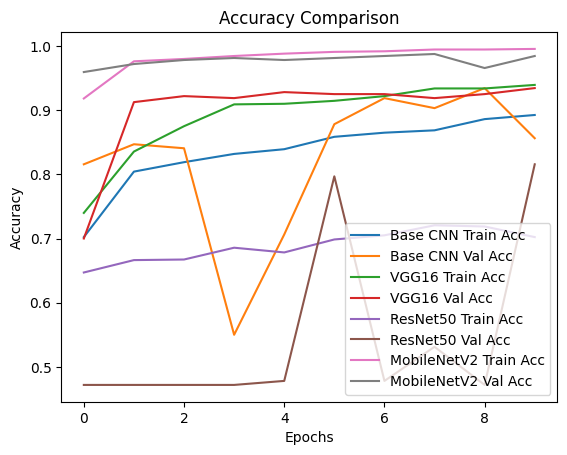

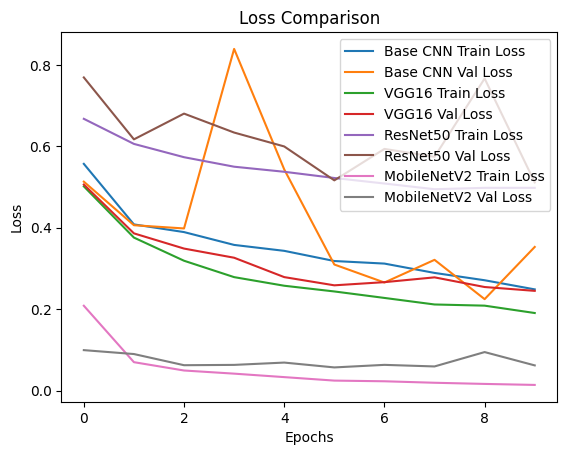

In [21]:
plot_metrics(
    [history_base, history_vgg16, history_resnet50, history_mobilenetv2],
    ['Base CNN', 'VGG16', 'ResNet50', 'MobileNetV2']
)

In [22]:
# Evaluation
models = [modelo2, vgg16_model, resnet50_model, mobilenetv2_model]
model_names = ['Base CNN', 'VGG16', 'ResNet50', 'MobileNetV2']
for model, name in zip(models, model_names):
    test_eval = model.evaluate(testIm, testCat, verbose=1)
    print(f'{name} - Validation loss: {test_eval[0]}, Validation accuracy: {test_eval[1]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.8592 - loss: 0.3757
Base CNN - Validation loss: 0.3527669906616211, Validation accuracy: 0.856249988079071


2024-12-09 00:35:44.031701: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-09 00:35:44.235113: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.203531404s
Trying algorithm eng12{k11=2} for conv (f32[32,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_qu

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - acc: 0.9173 - loss: 0.2801
VGG16 - Validation loss: 0.2449501007795334, Validation accuracy: 0.934374988079071
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - acc: 0.7850 - loss: 0.5274
ResNet50 - Validation loss: 0.5111697316169739, Validation accuracy: 0.815625011920929
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - acc: 0.9785 - loss: 0.0757
MobileNetV2 - Validation loss: 0.061924777925014496, Validation accuracy: 0.984375
